In [9]:
%matplotlib inline
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers
import pylab as pl

In [3]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

In [33]:
class SVM(object):

    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])
        #print(np.outer(y,y).shape, K.shape)
        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # solve QP problem
        cvxopt.solvers.options['show_progress'] = False
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-4
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print("%d support vectors out of %d points" % (len(self.a), n_samples))

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)

        # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None

    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))

In [5]:
    def split_train(X1, y1, X2, y2):
        X1_train = X1[:90]
        y1_train = y1[:90]
        X2_train = X2[:90]
        y2_train = y2[:90]
        X_train = np.vstack((X1_train, X2_train))
        y_train = np.hstack((y1_train, y2_train))
        return X_train, y_train

    def split_test(X1, y1, X2, y2):
        X1_test = X1[90:]
        y1_test = y1[90:]
        X2_test = X2[90:]
        y2_test = y2[90:]
        X_test = np.vstack((X1_test, X2_test))
        y_test = np.hstack((y1_test, y2_test))
        return X_test, y_test

    def plot_margin(X1_train, X2_train, clf):
        def f(x, w, b, c=0):
            # given x, return y such that [x,y] in on the line
            # w.x + b = c
            return (-w[0] * x - b + c) / w[1]

        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

        # w.x + b = 0
        a0 = -4; a1 = f(a0, clf.w, clf.b)
        b0 = 4; b1 = f(b0, clf.w, clf.b)
        pl.plot([a0,b0], [a1,b1], "k")

        # w.x + b = 1
        a0 = -4; a1 = f(a0, clf.w, clf.b, 1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, 1)
        pl.plot([a0,b0], [a1,b1], "k--")

        # w.x + b = -1
        a0 = -4; a1 = f(a0, clf.w, clf.b, -1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, -1)
        pl.plot([a0,b0], [a1,b1], "k--")

        pl.axis("tight")
        pl.show()

    def plot_contour(X1_train, X2_train, clf,xlim=[-6,6], ylim=[-6,6]):
        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        #pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

        X1, X2 = np.meshgrid(np.linspace(xlim[0],xlim[1],50), np.linspace(ylim[0],ylim[1],50))
        X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
        Z = clf.project(X).reshape(X1.shape)
        pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

        pl.axis("tight")
        
        pl.show()

## Linearly Separable Data

In [6]:
    def gen_lin_separable_data():
        # generate training data in the 2-d case
        mean1 = np.array([0, 2])
        mean2 = np.array([2, 0])
        cov = np.array([[0.8, 0.6], [0.6, 0.8]])
        X1 = np.random.multivariate_normal(mean1, cov, 100)
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 100)
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

In [7]:
    def test_linear():
        X1, y1, X2, y2 = gen_lin_separable_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)

        clf = SVM()
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print("%d out of %d predictions correct" % (correct, len(y_predict)))

        plot_margin(X_train[y_train==1], X_train[y_train==-1], clf)

((180, 180), (180, 180))
3 support vectors out of 180 points
20 out of 20 predictions correct


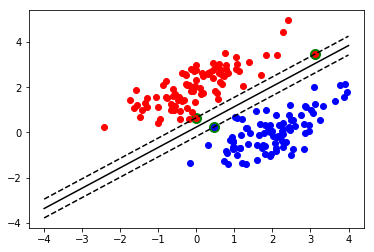

In [30]:
test_linear()

## Non-Linearly Separable Data

In [11]:
    def gen_non_lin_separable_data():
        mean1 = [-1, 2]
        mean2 = [1, -1]
        mean3 = [4, -4]
        mean4 = [-4, 4]
        cov = [[1.0,0.8], [0.8, 1.0]]
        X1 = np.random.multivariate_normal(mean1, cov, 50)
        X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 50)
        X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

In [12]:
    def test_non_linear():
        X1, y1, X2, y2 = gen_non_lin_separable_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)

        clf = SVM(polynomial_kernel)
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print("%d out of %d predictions correct" % (correct, len(y_predict)))

        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)

8 support vectors out of 180 points
20 out of 20 predictions correct


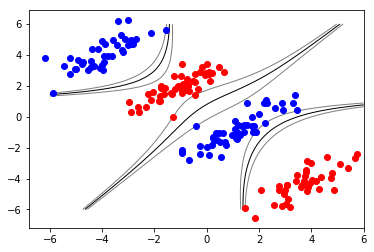

In [34]:
test_non_linear()

## Soft Margin (Slack Variables)

In [14]:
    def gen_lin_separable_overlap_data():
        # generate training data in the 2-d case
        mean1 = np.array([0, 2])
        mean2 = np.array([2, 0])
        cov = np.array([[1.5, 1.0], [1.0, 1.5]])
        X1 = np.random.multivariate_normal(mean1, cov, 100)
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 100)
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2


In [15]:
    def test_soft():
        X1, y1, X2, y2 = gen_lin_separable_overlap_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)

        clf = SVM(C=10000)
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print("%d out of %d predictions correct" % (correct, len(y_predict)))

        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)

27 support vectors out of 180 points
19 out of 20 predictions correct


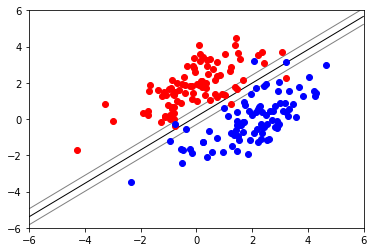

In [35]:
test_soft()

# Observations

## 1. Effect of C

In [20]:
x= [[-4,4],
   [-3,3],
   [2,2],[1,1],[2.1,2.1]]
y=[-1,-1,1,1,-1]

#### C=1

((5, 5), (5, 5))
     pcost       dcost       gap    pres   dres
 0: -2.4334e+00 -8.8075e+00  3e+01  2e+00  2e-15
 1: -1.8637e+00 -4.9903e+00  3e+00  2e-02  9e-16
 2: -2.0416e+00 -2.3300e+00  3e-01  2e-03  4e-16
 3: -2.1038e+00 -2.1284e+00  2e-02  2e-16  2e-16
 4: -2.1105e+00 -2.1128e+00  2e-03  1e-16  6e-16
 5: -2.1111e+00 -2.1113e+00  2e-04  3e-16  5e-16
 6: -2.1111e+00 -2.1111e+00  2e-05  2e-16  3e-16
 7: -2.1111e+00 -2.1111e+00  2e-07  1e-16  6e-16
Optimal solution found.
4 support vectors out of 5 points


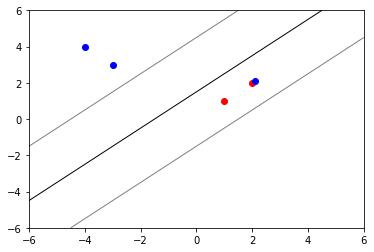

In [21]:
##########here c=1 it will let one blue point misclassify but c=10000 it wont let
clf = SVM(C=1, kernel=linear_kernel)
x=np.array(x, dtype='float')
y=np.array(y, dtype='float')
clf.fit(x, y)

plot_contour(x[y==1], x[y==-1], clf)

#### C=100

((5, 5), (5, 5))
     pcost       dcost       gap    pres   dres
 0:  5.8954e+02 -1.8294e+04  2e+04  1e-01  8e-14
 1:  3.3014e+02 -1.3328e+03  2e+03  6e-03  2e-13
 2: -7.4176e+00 -2.2024e+02  2e+02  4e-04  3e-14
 3: -1.2924e+02 -1.5889e+02  3e+01  2e-05  5e-14
 4: -1.3262e+02 -1.3457e+02  2e+00  1e-06  8e-14
 5: -1.3288e+02 -1.3291e+02  3e-02  1e-08  3e-14
 6: -1.3289e+02 -1.3289e+02  3e-04  1e-10  5e-14
 7: -1.3289e+02 -1.3289e+02  3e-06  1e-12  3e-14
Optimal solution found.
3 support vectors out of 5 points


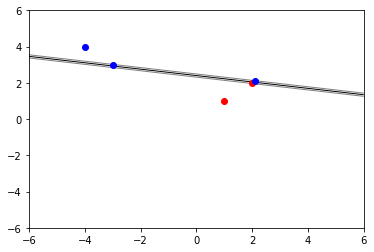

In [23]:
clf = SVM(C=100, kernel=linear_kernel)
x=np.array(x, dtype='float')
y=np.array(y, dtype='float')
clf.fit(x, y)

plot_contour(x[y==1], x[y==-1], clf)

### Changing Kernel

((5, 5), (5, 5))
     pcost       dcost       gap    pres   dres
 0: -2.3364e+00 -9.2785e+00  3e+01  2e+00  5e-13
 1: -1.7323e+00 -5.6344e+00  8e+00  4e-01  3e-13
 2: -9.4623e-01 -2.8169e+00  4e+00  2e-01  4e-13
 3:  2.0484e-02 -4.2952e-01  9e-01  3e-02  2e-13
 4: -7.1728e-03 -3.9222e-02  3e-02  9e-17  8e-15
 5: -1.5522e-02 -1.9133e-02  4e-03  1e-16  3e-15
 6: -1.7300e-02 -1.7376e-02  8e-05  1e-16  2e-15
 7: -1.7321e-02 -1.7322e-02  8e-07  1e-16  3e-15
 8: -1.7321e-02 -1.7321e-02  8e-09  3e-17  2e-15
Optimal solution found.
3 support vectors out of 5 points


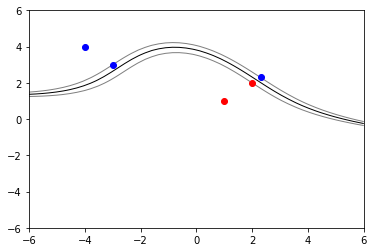

In [25]:
### p=2 or p=3 would woek just fine
x= [[-4,4],
       [-3,3],
       [2,2],[1,1],[2.3,2.3]]
y=[-1,-1,1,1,-1]

def polynomial_kernel_1(x, y, p=3):
    return (np.dot(x, y)) ** p


clf = SVM(C=1, kernel=polynomial_kernel_1)
x=np.array(x, dtype='float')
y=np.array(y, dtype='float')
clf.fit(x, y)

        
plot_contour(x[y==1], x[y==-1], clf)

### Circular Data

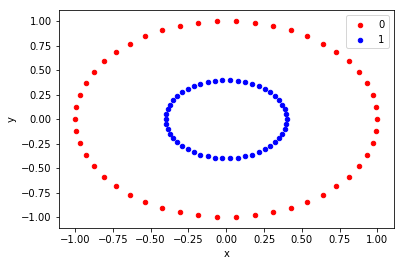

In [26]:
%matplotlib inline
from sklearn.datasets import make_circles
from matplotlib import pyplot
from pandas import DataFrame
# generate 2d classification dataset
X, y = make_circles(n_samples=100, noise=0, factor=0.4)
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [37]:
x = X
y[y==0]=-1

In [50]:
z = [((p[0]**2) + (p[1]**2))**0.5 for p in x]

In [82]:
x = [[x[i][0],z[i]**3] for i in range(len(x))]

In [38]:

def quadratic_kernel(x, y, p=2):
    return (np.dot(x, y)) ** p

100 support vectors out of 100 points


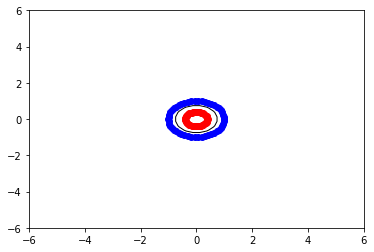

In [42]:
clf = SVM(C=1, kernel=quadratic_kernel)
x=np.array(X, dtype='float')
y=np.array(y, dtype='float')
clf.fit(x, y)

        
plot_contour(x[y==1], x[y==-1], clf)